This notebook will be mainly used for the ___Coursera_Capstone Week 4 & 5___ project:

___Peer-graded Assignment: The Battle of Neighborhoods___

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import os

In [2]:
!conda install -c conda-forge geopy --yes  # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0          conda-forge
    geopy:           

## Data Acquisition and Cleaning

1. Read Houston Super Neighborhoods Data from Wikipedia

In [3]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_Houston_neighborhoods')[0]
df.head()

#                            Name Location relative to Downtown Houston  \
0  1                     Willowbrook                             Northwest   
1  2             Greater Greenspoint                                 North   
2  3                      Carverdale                             Northwest   
3  4  Fairbanks / Northwest Crossing                             Northwest   
4  5                  Greater Inwood                             Northwest   

                              Approximate boundaries  
0  Along Texas State Highway 249 northwest of Bel...  
1  Around the junction of Beltway 8 and Interstat...  
2  South of the junction of Beltway 8 and U.S. Ro...  
3  Along U.S. Route 290 between Interstate 610 an...  
4  North of Fairbanks / Northwest Crossing and ea...

In [5]:
df.shape

(88, 1)

2. Read Data, Barc dog intakes for calendar years 2011-2012.  

In [6]:
df1 = pd.read_csv('https://opendatahouston.s3.amazonaws.com/2013-05-13T20:00:59.773Z/barc-dog-intakes-for-calendar-years-2011-and-2012.csv')
df1.head()

id  tot type           breed sub_breed     in_type   in_sub  \
0  A1059900    1  DOG        PIT BULL       MIX  CONFISCATE  CRUELTY   
1  A1062552    1  DOG        PIT BULL       MIX  CONFISCATE     BITE   
2  A1046026    1  DOG  FLAT COAT RETR       MIX  CONFISCATE   POLICE   
3  A1070150    1  DOG   LABRADOR RETR       MIX  CONFISCATE     BITE   
4  A1069139    1  DOG   LABRADOR RETR       NaN  CONFISCATE     BITE   

   condition   in_date  due_date  out_type     out_sub  out_date  zip  \
0  CONDSEVER   7/18/11   7/23/11  TRANSFER  RESCUE GRP   7/22/11  NaN   
1     NORMAL   8/16/11   8/26/11       RTO      WALKIN   8/27/11  NaN   
2     NORMAL   1/29/11   2/27/11  TRANSFER  RESCUE GRP   3/11/11  NaN   
3     NORMAL  11/16/11  11/26/11       RTO      WALKIN  11/26/11  NaN   
4       DEAD   11/4/11   11/4/11      DIED      AT VET   11/4/11  NaN   

   street_num       street_name  AC  days            address        lat  \
0     17630.0      WAYFOREST     UU   4.0    17630 WAYFOREST  29.954586   
1      8016.0   OAKWOOD BEND      H  11.0  8016 OAKWOOD BEND  29.868617   
2         0.0                     H  41.0                  0        NaN   
3     15902.0    HEATHERDALE      H  10.0  15902 HEATHERDALE  29.590685   
4      2410.0       GRAMERCY     UU   0.0      2410 GRAMERCY  29.704660   

        long  
0 -95.391600  
1 -95.511768  
2        NaN  
3 -95.114748  
4 -95.415228

Only intake location is focused.

In [7]:
df2 = df1[['lat','long']]
df2 = df2[df2['lat'].notna()]
df2.shape

(31714, 2)

Outlier points are removed.

In [8]:
df3 = df2.groupby(['lat','long']).count()
df3.reset_index(inplace = True)
df3 = df3.sort_values(by=['lat']).iloc[1:]
df3 = df3.iloc[:12026]
df3.head()

lat       long
1  29.191882 -95.407507
2  29.279458 -95.651117
3  29.451129 -95.838863
4  29.462405 -95.472163
5  29.478307 -95.155772

In [9]:
df3 = df3.sort_values(by=['long'])
df3.head()

lat       long
12026  30.911731 -99.785589
11882  30.046815 -96.297647
8544   29.830829 -96.184766
12015  30.211108 -96.003000
6299   29.782836 -95.938521

In [10]:
df3 = df3.drop(index = 12026)
df3.head()

lat       long
11882  30.046815 -96.297647
8544   29.830829 -96.184766
12015  30.211108 -96.003000
6299   29.782836 -95.938521
12006  30.172829 -95.897472

In [11]:
df3.reset_index(inplace = True)
df3.head()


index        lat       long
0  11882  30.046815 -96.297647
1   8544  29.830829 -96.184766
2  12015  30.211108 -96.003000
3   6299  29.782836 -95.938521
4  12006  30.172829 -95.897472

In [136]:
df_intake = df3.drop(['index'], axis =1)
df_intake.head()

lat       long
0  30.046815 -96.297647
1  29.830829 -96.184766
2  30.211108 -96.003000
3  29.782836 -95.938521
4  30.172829 -95.897472

## Exploratory Data Analysis

1. Check Intake Location Distribution in Houston, TX.

In [137]:
latitude = 29.7604   
longitude = -95.3698
map_hou_dog_intake = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng in zip(df_intake['lat'], df_intake['long']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hou_dog_intake)  
    
map_hou_dog_intake

2. Segment Intake Locations into Clusters. Since Houston has 88 super neighborhoods, intake locations are seperated into 88 clusters.
   KMeans clustering model is used. 

In [57]:
kclusters = 88

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_intake)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([39, 39, 26, 10, 26, 26, 26, 49, 10, 49], dtype=int32)

In [58]:
df_intake.insert(0, 'Cluster Labels', kmeans.labels_)

3. For each cluster, intake dog number is calcualted and visualized.

In [59]:
df_count = df_intake.groupby('Cluster Labels').count()[['lat']]
df_count = df_count.rename(columns={'lat': 'count'})
df_count.head()

count
Cluster Labels       
0                 296
1                 152
2                 223
3                  36
4                  73

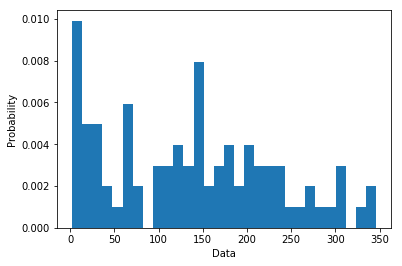

In [134]:
import matplotlib.pyplot as plt
plt.hist(df_count['count'], density=True, bins=30)
plt.xlabel('Data')
plt.ylabel('Probability')

plt.show()

In [60]:
df_intake = df_intake.groupby('Cluster Labels').mean()
df_intake.head()

lat       long
Cluster Labels                      
0               29.859336 -95.343232
1               29.687002 -95.547812
2               29.706621 -95.283226
3               30.053392 -95.245525
4               29.960869 -95.436336

In [61]:
df_dog_intake = pd.concat([df_intake,df_count], axis = 1)
df_dog_intake.head()

lat       long  count
Cluster Labels                             
0               29.859336 -95.343232    296
1               29.687002 -95.547812    152
2               29.706621 -95.283226    223
3               30.053392 -95.245525     36
4               29.960869 -95.436336     73

In [70]:
df_dog_intake.reset_index(inplace= True)

In [71]:
df_dog_intake.head()

Cluster Labels        lat       long  count
0               0  29.859336 -95.343232    296
1               1  29.687002 -95.547812    152
2               2  29.706621 -95.283226    223
3               3  30.053392 -95.245525     36
4               4  29.960869 -95.436336     73

In [75]:
df_dog_intake.shape

(88, 4)

4. Clustered dog intake distribution is shown below.

In [66]:
latitude = 29.7604   
longitude = -95.3698
map_hou_dog_intake = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_dog_intake['lat'], df_dog_intake['long'], df_dog_intake['count']):
    folium.CircleMarker(
        [lat, lng],
        popup = str(label),
        radius=5,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hou_dog_intake)  
    
map_hou_dog_intake

## Retrieve Pet Stores Around Dog Intake Locations

1. Define Foursquare credentials and version

In [67]:
CLIENT_ID = 'DHQDXLC45ETLXROILOH2YEYWSRB3DI3XM0LE4JQANFHUKMNE' # your Foursquare ID
CLIENT_SECRET = 'ZGVWQEX3JY2AZJKYQ4ACT3CYT5RMS2FJZELBIL4SUZTEHYYQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DHQDXLC45ETLXROILOH2YEYWSRB3DI3XM0LE4JQANFHUKMNE
CLIENT_SECRET:ZGVWQEX3JY2AZJKYQ4ACT3CYT5RMS2FJZELBIL4SUZTEHYYQ


2. Define function, getNearbyVenues.

In [89]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Cluster Labels',
                  'Intake Latitude', 
                  'Intake Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Get city Toronto nearby venues.

In [91]:
houston_venues = getNearbyVenues(names=df_dog_intake['Cluster Labels'],
                                 latitudes=df_dog_intake['lat'],
                                   longitudes=df_dog_intake['long']
                                  )
houston_venues.head()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87


Cluster Labels  Intake Latitude  Intake Longitude               Venue  \
0               0        29.859336        -95.343232         Chick-fil-A   
1               0        29.859336        -95.343232           Mi Tienda   
2               0        29.859336        -95.343232      The Home Depot   
3               0        29.859336        -95.343232   City Acre Brewing   
4               0        29.859336        -95.343232  Spindletap Brewery   

   Venue Latitude  Venue Longitude        Venue Category  
0       29.870384       -95.328027  Fast Food Restaurant  
1       29.869838       -95.332414         Grocery Store  
2       29.867187       -95.329363        Hardware Store  
3       29.856647       -95.334856               Brewery  
4       29.867719       -95.315186               Brewery

In [92]:
venue_pet = houston_venues[houston_venues['Venue Category'].str.contains('Pet')]

print(venue_pet.count())
venue_pet.head()

Cluster Labels      53
Intake Latitude     53
Intake Longitude    53
Venue               53
Venue Latitude      53
Venue Longitude     53
Venue Category      53
dtype: int64


Cluster Labels  Intake Latitude  Intake Longitude           Venue  \
329               3        30.053392        -95.245525           Petco   
387               3        30.053392        -95.245525        PetSmart   
391               3        30.053392        -95.245525      Animal Ark   
639               6        29.844780        -95.550552  Aquarium World   
660               6        29.844780        -95.550552        PetSmart   

     Venue Latitude  Venue Longitude Venue Category  
329       30.049813       -95.244298      Pet Store  
387       30.014236       -95.260582      Pet Store  
391       30.067745       -95.196330      Pet Store  
639       29.846201       -95.504434      Pet Store  
660       29.855734       -95.513606      Pet Store

In [95]:
pet_count = venue_pet.groupby('Cluster Labels').count()[['Venue Category']]
pet_count.reset_index(inplace= True)
pet_count.head()

Cluster Labels  Venue Category
0               3               3
1               6               2
2               8               1
3              10               1
4              11               1

In [120]:
houston_dog_merge = pd.merge(df_dog_intake, pet_count, how = 'left', on = 'Cluster Labels')
houston_dog_merge['Venue Category'] = houston_dog_merge['Venue Category'].fillna(0).astype(int)
houston_dog_merge.head()

Cluster Labels        lat       long  count  Venue Category
0               0  29.859336 -95.343232    296               0
1               1  29.687002 -95.547812    152               0
2               2  29.706621 -95.283226    223               0
3               3  30.053392 -95.245525     36               3
4               4  29.960869 -95.436336     73               0

Normalized clustering data

In [123]:
houston_cluster = houston_dog_merge.drop(['Cluster Labels', 'lat', 'long'], axis=1)
houston_cluster = houston_cluster/houston_cluster.sum()
houston_cluster.head()

count  Venue Category
0  0.024615        0.000000
1  0.012640        0.000000
2  0.018545        0.000000
3  0.002994        0.056604
4  0.006071        0.000000

Get city Toronto venues categories.

Group city Toronto venues and show average count of categories.

## Predictive Modeling

Run k-means to cluster the dataset into 4 clusters.

In [124]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(houston_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 3, 0, 2, 3, 0, 2, 0, 1, 0], dtype=int32)

In [125]:
houston_dog_merge.insert(0, 'Cluster Groups', kmeans.labels_)

houston_dog_merge.head() # check the last columns!

Cluster Groups  Cluster Labels        lat       long  count  Venue Category
0               0               0  29.859336 -95.343232    296               0
1               3               1  29.687002 -95.547812    152               0
2               0               2  29.706621 -95.283226    223               0
3               2               3  30.053392 -95.245525     36               3
4               3               4  29.960869 -95.436336     73               0

Visualize the resulting clusters.

In [126]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, intake, petstore, cluster in zip( houston_dog_merge['lat'], houston_dog_merge['long'], houston_dog_merge['count'], houston_dog_merge['Venue Category'], houston_dog_merge['Cluster Groups']):
    label = folium.Popup('Cluster '+ str(cluster) + ' Intake ' + str(intake) + ' PetStore ' + str(petstore), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

 ## Conclusions / Examine Clusters

#### ___Cluster 1___

In [127]:
houston_dog_merge.loc[houston_dog_merge['Cluster Groups'] == 0]

Cluster Groups  Cluster Labels        lat       long  count  \
0                0               0  29.859336 -95.343232    296   
2                0               2  29.706621 -95.283226    223   
5                0               5  29.779839 -95.360767    310   
7                0               7  29.620882 -95.427172    203   
9                0               9  29.790778 -95.329499    346   
13               0              13  29.708828 -95.321404    179   
19               0              19  29.657411 -95.366581    180   
23               0              23  29.835600 -95.280703    262   
35               0              35  29.591165 -95.477273    193   
37               0              37  29.886588 -95.298253    172   
40               0              40  29.733335 -95.365217    215   
44               0              44  29.825263 -95.333862    284   
50               0              50  29.696685 -95.365516    190   
62               0              62  29.671450 -95.297307    237   
64               0              64  29.736012 -95.296119    199   
65               0              65  29.689660 -95.498142    200   
70               0              70  29.852883 -95.307280    271   
72               0              72  29.743797 -95.331750    247   
73               0              73  29.681422 -95.253619    212   
74               0              74  29.885132 -95.423855    180   
75               0              75  29.675206 -95.336509    274   
76               0              76  29.698352 -95.584531    210   
82               0              82  29.803839 -95.365069    335   
83               0              83  29.780344 -95.304259    326   
84               0              84  29.865934 -95.374002    308   

    Venue Category  
0                0  
2                0  
5                0  
7                0  
9                0  
13               0  
19               0  
23               0  
35               0  
37               0  
40               0  
44               0  
50               0  
62               0  
64               0  
65               0  
70               0  
72               0  
73               0  
74               0  
75               0  
76               0  
82               1  
83               0  
84               0

#### ___Cluster 2___

In [128]:
houston_dog_merge.loc[houston_dog_merge['Cluster Groups'] == 1]

Cluster Groups  Cluster Labels        lat       long  count  \
8                1               8  29.616110 -95.268174    112   
10               1              10  29.729054 -95.796402     12   
11               1              11  29.825246 -95.505462    184   
12               1              12  29.720225 -95.618850    128   
14               1              14  29.866017 -95.461124    208   
16               1              16  29.630135 -95.103346     17   
17               1              17  29.786098 -95.186587    167   
18               1              18  29.926974 -95.578365     68   
21               1              21  29.892371 -95.650921     66   
22               1              22  30.231837 -95.527882      9   
30               1              30  29.668899 -95.593613    169   
31               1              31  30.099920 -95.419619     20   
34               1              34  30.033139 -95.117172     31   
43               1              43  29.785747 -95.412548    239   
47               1              47  29.829995 -95.683443     56   
54               1              54  29.800494 -95.542450    136   
58               1              58  30.014867 -95.449535     39   
60               1              60  30.068224 -95.192505     68   
66               1              66  29.802456 -95.482544    122   
69               1              69  29.949919 -95.171002     31   
71               1              71  30.032382 -95.549625     24   
77               1              77  29.634795 -95.236873    151   
78               1              78  29.790667 -95.743011     30   
86               1              86  30.011512 -95.633341     15   
87               1              87  29.499731 -95.099679     11   

    Venue Category  
8                1  
10               1  
11               1  
12               1  
14               1  
16               1  
17               1  
18               1  
21               1  
22               1  
30               1  
31               1  
34               1  
43               1  
47               1  
54               1  
58               1  
60               1  
66               1  
69               1  
71               1  
77               1  
78               1  
86               1  
87               1

#### ___Cluster 2___

In [129]:
houston_dog_merge.loc[houston_dog_merge['Cluster Groups'] == 2]

Cluster Groups  Cluster Labels        lat       long  count  \
3                2               3  30.053392 -95.245525     36   
6                2               6  29.844780 -95.550552     78   
20               2              20  29.820762 -95.397759    232   
24               2              24  29.688653 -95.427607    124   
27               2              27  29.631130 -95.205630     66   
36               2              36  29.687055 -95.170188     19   
41               2              41  29.835043 -95.366564    308   
42               2              42  29.879173 -95.499495    148   
52               2              52  29.855720 -95.405465    220   
55               2              55  29.668575 -95.668380     40   
56               2              56  29.826635 -95.447863    220   
81               2              81  29.586764 -95.212040     99   

    Venue Category  
3                3  
6                2  
20               2  
24               2  
27               2  
36               2  
41               2  
42               2  
52               2  
55               3  
56               3  
81               2

#### ___Cluster 3___

In [130]:
houston_dog_merge.loc[houston_dog_merge['Cluster Groups'] == 3]

Cluster Groups  Cluster Labels        lat       long  count  \
1                3               1  29.687002 -95.547812    152   
4                3               4  29.960869 -95.436336     73   
15               3              15  29.754077 -95.268651    106   
25               3              25  29.647812 -95.501272    141   
26               3              26  30.147539 -95.871130      5   
28               3              28  29.741210 -95.406112    153   
29               3              29  29.747170 -95.572974    122   
32               3              32  29.946167 -95.293732     60   
33               3              33  29.725610 -95.527895    139   
38               3              38  29.929674 -95.397383    138   
39               3              39  29.938822 -96.241207      2   
45               3              45  29.766504 -95.614003    104   
46               3              46  29.235670 -95.529312      2   
48               3              48  30.352693 -95.102322      3   
49               3              49  29.509574 -95.774990      4   
51               3              51  30.024424 -95.345320     33   
53               3              53  29.798058 -95.052581     12   
57               3              57  29.848608 -95.244459    142   
59               3              59  29.650986 -95.535997    114   
61               3              61  29.571889 -95.126620    105   
63               3              63  29.736851 -95.477553    150   
67               3              67  29.780400 -95.230067    147   
68               3              68  29.623322 -95.347853    150   
79               3              79  29.639170 -95.466612    148   
80               3              80  30.304163 -95.345575      5   
85               3              85  29.954709 -95.499169     60   

    Venue Category  
1                0  
4                0  
15               0  
25               0  
26               0  
28               0  
29               0  
32               0  
33               0  
38               0  
39               0  
45               0  
46               0  
48               0  
49               0  
51               0  
53               0  
57               0  
59               0  
61               0  
63               0  
67               0  
68               0  
79               0  
80               0  
85               0